<a href="https://colab.research.google.com/github/allfitra/CNN_Model-Python/blob/main/CNN_Model_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolution Neural Network (CNN) Model** *by-Allfitra*

# **DATASET & VISUALIZATION**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# change according to your data location

!ls /content/drive/Dataset/
datasetFile = '/content/drive/Dataset/Dataset.xlsx'

In [ ]:
!pip install matplotlib

In [ ]:
import pandas as pd
commentsDataset = pd.read_excel(datasetFile)
commentsDataset

,Komentar,Label
0,wow tempat nya indah jg luas ..smg yg terbaik ...,Positif
1,Kampus yang cantik dan dengan fasilitasnya yan...,Positif
2,Universitas negeri jakarta Tempatnya luas sek...,Positif
3,Selamat siang bang Keren sekali kampus UNJ ya...,Positif
4,Sangat luas sekali tempat nya dan terimakasih ...,Positif
...,...,...
2925,Makanya tanam chip tuh di otak bukan di teringga,Negatif
2926,Apa masih ada mengandalkan kekuatan orang dalam,Negatif
2927,unj mah ga ada fk. Itu mau ambil jurusan kedok...,Negatif
2928,Mampus wkwk\n Soal sbmptn lo lumayan bisa dike...,Negatif


In [ ]:
textData = commentsDataset['Komentar'].tolist()
labelData = commentsDataset['Label'].map({'Negatif' : 0, 'Positif' : 1}).tolist()

print(len(textData))
print(len(labelData))

2930
2930


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(textData, labelData, test_size=0.1465, random_state=25)

print(f"Training Data : {len(X_train)}, {len(y_train)}")
print(f"Testing Data  : {len(X_test)} , {len(y_test)}")

Training Data : 2500, 2500
Testing Data  : 430 , 430


In [ ]:
labels_df = pd.DataFrame({'labels_train': y_train}).replace({0: 'negative', 1: 'positive'})
labels_df['labels_test'] = pd.DataFrame(y_test).replace({0: 'negative', 1: 'positive'})

In [ ]:
label_counts = commentsDataset['Label'].value_counts()
label_train_counts = labels_df['labels_train'].value_counts()
label_test_counts = labels_df['labels_test'].value_counts()
print(label_counts)
print(label_train_counts)
print(label_test_counts)

Label
Negatif    1479
Positif    1451
Name: count, dtype: int64
labels_train
positive    1251
negative    1249
Name: count, dtype: int64
labels_test
negative    230
positive    200
Name: count, dtype: int64


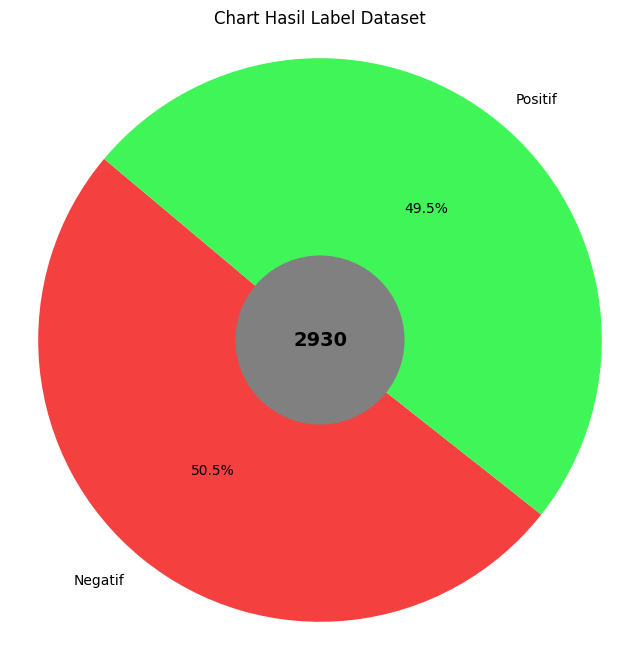

In [ ]:
import matplotlib.pyplot as plt

total = label_counts.sum()
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=['#f54040', '#40f558'])

# Draw a circle at the center of pie to create a donut chart
centre_circle = plt.Circle((0, 0), 0.30, fc='grey')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Chart Hasil Label Dataset")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add total count in the center
plt.text(0, 0, f'{total}', horizontalalignment='center', verticalalignment='center', fontsize=14, weight='bold')

plt.show()

# **PREPROCESSING**

In [ ]:
# Install Module
!pip install sastrawi
!pip install nltk

In [ ]:
import re
# import nltk
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# data normalisasi
normalize_data = pd.read_excel('/content/drive/Dataset/Normalisasi.xlsx')
replacement_table = pd.Series(normalize_data.hasil.values, index=normalize_data.word).to_dict()

# data stopword
Stopword_data = pd.read_excel('/content/drive/Dataset/Stopword.xlsx')
custom_stopwords = Stopword_data['kata'].tolist()

factory = StopWordRemoverFactory()
default_stopwords = factory.get_stop_words()  # default stopwords from Sastrawi
all_stopwords = set(default_stopwords).union(set(custom_stopwords)) # combining built-in stopwords and manual stopwords

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

class Preprocessing:
    def __init__(self, text):
        self.text = text

    #Case Folding
    def lower_case(self):
      return self.text.lower()

    #Cleaning
    def cleaning(self):
        # Remove any remaining non-alphabet characters
        self.text = re.sub(r'[^a-zA-Z\s]', ' ', self.text)
        # Remove consecutive letters
        self.text = re.sub(r'(.)\1{2,}', r'\1', self.text)
        # Remove single characters
        self.text = re.sub(r'\b[a-zA-Z]\b', ' ', self.text)
        # Remove multiple spaces
        self.text = re.sub(r'\s+', ' ', self.text)
        # Strip leading/trailing spaces
        self.text = self.text.replace('\n', ' ').strip()
        return self.text

    #Tokenizing
    def tokenizing(self):
      return self.text.split()

    #Normalization
    def normalize(self):
        return [replacement_table.get(word, word) for word in self.text]

    #Stopword Removal
    def remove_stopwords(self):
        return [word for word in self.text if word not in all_stopwords]

    #Stemming
    def stem(self):
        return [stemmer.stem(word) for word in self.text]



In [ ]:
def preprocessing(text):
    processed_text = Preprocessing(text).lower_case()
    processed_text = Preprocessing(processed_text).cleaning()
    processed_text = Preprocessing(processed_text).tokenizing()
    processed_text = Preprocessing(processed_text).normalize()
    processed_text = Preprocessing(processed_text).remove_stopwords()
    processed_text = Preprocessing(processed_text).stem()
    return processed_text

# **EKSTRAKSI FEATURE**

In [ ]:
import numpy as np
from gensim.models import Word2Vec

class SetPadding :
  def __init__(self, texts, max_len=None):
    self.texts = texts;
    self.list_vocab = self.build_vocab()
    self.max_len = max_len if max_len is not None else max(len(text) for text in texts);

  def build_vocab(self):
    list_vocab = {word: wordId + 1 for wordId, word in enumerate(set(word for text in self.texts for word in text))}
    return list_vocab;

  def pad_sequences(self, texts):
    X = np.zeros((len(texts), self.max_len), dtype=int)
    for i, text in enumerate(texts):
      for j, word in enumerate(text):
        if j < self.max_len:
          X[i, j] = self.list_vocab.get(word, 0)
    return X


In [ ]:
class WordEmbedding:
    def __init__(self, tokenized_texts, embedding_dim):
        self.embedding_dim = embedding_dim
        self.model = self.train_word2vec(tokenized_texts, embedding_dim)
        self.vocab_size = len(self.model.wv)

    def train_word2vec(self, tokenized_texts, embedding_dim):
        model = Word2Vec(sentences=tokenized_texts, vector_size=embedding_dim, window=5, min_count=1, workers=4)
        return model

    def forward(self, X):
        embedding_matrix = np.zeros((X.shape[0], X.shape[1], self.embedding_dim))
        for i, sentence in enumerate(X):
            for j, word_idx in enumerate(sentence):
                    word = self.model.wv.index_to_key[word_idx - 1]
                    embedding_matrix[i, j] = self.model.wv[word]
        return embedding_matrix

##**Word Cloud**

In [ ]:
!pip install wordcloud

In [ ]:
textPreprocessed_all = commentsDataset['Komentar'].apply(preprocessing).tolist()

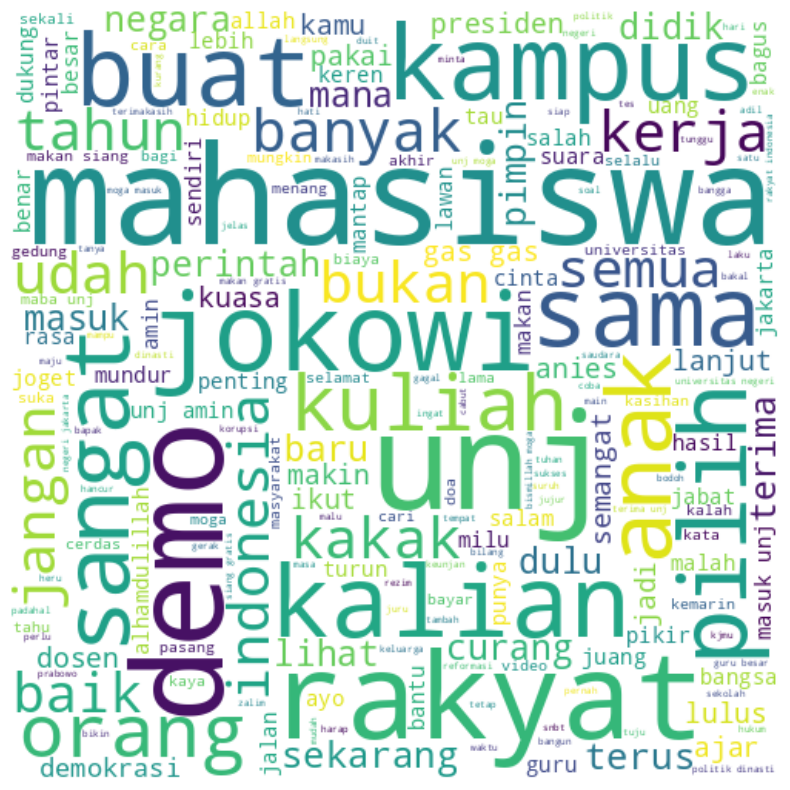

In [ ]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all text and change to string
text = ' '.join([item for sublist in textPreprocessed_all for item in sublist])

# Create a WordCloud object
wc = WordCloud(background_color='white', width=500, height=500).generate(text)

# Display the WordCloud
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

plt.savefig('wordcloud_image.png', format='png', bbox_inches='tight')
plt.show()

# **CONVOLUTION NEURAL NETWORK (CNN) MODEL**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

class CNNClassifier:
    def __init__(self, preprocessor, num_filters, filter_size, num_classes, embedding_dim, embedding_layer, learning_rate=0.01):
        self.preprocessor = preprocessor
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.num_classes = num_classes
        self.max_len = preprocessor.max_len
        self.embedding_dim = embedding_dim
        self.embedding_layer = embedding_layer
        self.learning_rate = learning_rate
        self.final_prediction = []

        # Initialize weights
        self.conv_filters = np.random.randn(num_filters, filter_size, embedding_dim)
        self.fc_weights = np.random.randn(num_filters, num_classes)
        self.fc_bias = np.random.randn(num_classes)

    def forward(self, embedded):
        # Convolutional layer
        batch_size = len(embedded)
        conv_out = np.zeros((batch_size, self.num_filters, self.max_len - self.filter_size + 1))

        for i in range(batch_size):
            for j in range(self.num_filters):
                for k in range(self.max_len - self.filter_size + 1):
                    conv_out[i, j, k] = np.sum(embedded[i, k:k+self.filter_size] * self.conv_filters[j])

        # Apply ReLU activation
        # conv_out = np.maximum(0, conv_out)

        # Pooling layer (max pooling)
        pooled = np.max(conv_out, axis=2)

        # Fully connected layer
        fc_out = np.dot(pooled, self.fc_weights) + self.fc_bias

        # Output layer (softmax)
        exp_scores = np.exp(fc_out - np.max(fc_out, axis=1, keepdims=True))
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return probs, pooled, conv_out

    def compute_loss(self, probs, labels):
        correct_logprobs = -np.log(probs[np.arange(len(labels)), labels])
        loss = np.mean(correct_logprobs)
        return loss

    def backward(self, embedded, probs, labels, pooled, conv_out, X):
        batch_size = len(labels)

        # Gradient of the loss with respect to output scores
        d_fc_out = probs
        d_fc_out[np.arange(batch_size), labels] -= 1
        d_fc_out /= batch_size

        # Gradients for fully connected layer
        d_fc_weights = np.dot(pooled.T, d_fc_out)
        d_fc_bias = np.sum(d_fc_out, axis=0)

        # Gradient for pooled layer
        d_pooled = np.dot(d_fc_out, self.fc_weights.T)

        # Gradient for convolutional layer (max pooling)
        d_conv_out = np.zeros_like(conv_out)
        for i in range(batch_size):
            for j in range(self.num_filters):
                max_indices = np.where(conv_out[i, j] == pooled[i, j])[0]
                d_conv_out[i, j, max_indices] = d_pooled[i, j]

        # Gradient for convolution filters
        d_conv_filters = np.zeros_like(self.conv_filters)
        for i in range(batch_size):
            for j in range(self.num_filters):
                for k in range(self.max_len - self.filter_size + 1):
                    d_conv_filters[j] += d_conv_out[i, j, k] * embedded[i, k:k+self.filter_size]

        # Gradient for embedding layer
        d_embedding_matrix = np.zeros_like(self.embedding_layer.model.wv.vectors)
        for i in range(batch_size):
            for j in range(self.num_filters):
                for k in range(self.max_len - self.filter_size + 1):
                    for l in range(self.filter_size):
                        word_idx = X[i, k+l]
                        if word_idx != 0:  # Skip padding
                            word = list(self.embedding_layer.model.wv.index_to_key)[word_idx - 1]
                            d_embedding_matrix[word_idx - 1] += d_conv_out[i, j, k] * self.conv_filters[j, l]

        return d_embedding_matrix, d_conv_filters, d_fc_weights, d_fc_bias

    def update_weights(self, d_embedding_matrix, d_conv_filters, d_fc_weights, d_fc_bias):
        self.embedding_layer.model.wv.vectors -= self.learning_rate * d_embedding_matrix
        self.conv_filters -= self.learning_rate * d_conv_filters
        self.fc_weights -= self.learning_rate * d_fc_weights
        self.fc_bias -= self.learning_rate * d_fc_bias

    def train(self, X, labels, epochs):
        for epoch in range(epochs):
            embedded = self.embedding_layer.forward(X)
            print(len(embedded))
            probs, pooled, conv_out = self.forward(embedded)
            loss = self.compute_loss(probs, labels)

            predictions = np.argmax(probs, axis=1)
            accuracy = np.mean(predictions == labels) * 100

            # print(probs)
            print(predictions)
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%')

            d_embedding_matrix, d_conv_filters, d_fc_weights, d_fc_bias = self.backward(embedded, probs, labels, pooled, conv_out, X)
            self.update_weights(d_embedding_matrix, d_conv_filters, d_fc_weights, d_fc_bias)

        self.final_prediction = predictions
        print("Training completed.")


    def evaluate(self, X_test, Y_test):
        embedded = self.embedding_layer.forward(X_test)
        probs, _, _ = self.forward(embedded)
        loss = self.compute_loss(probs, Y_test)

        predictions = np.argmax(probs, axis=1)

        accuracy = np.mean(predictions == Y_test) * 100
        precision = precision_score(Y_test, predictions, average='weighted')
        recall = recall_score(Y_test, predictions, average='weighted')

        print(f' Loss: {loss:.4f}, Accuracy on testing data: {accuracy:.2f}%')
        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')

        return accuracy, precision, recall

    def predict(self, text):
        # Tokenize and pad the input text
        input_data = preprocessing(text)
        final_data = self.preprocessor.pad_sequences([input_data])
        # preprocessor.pad_sequences([input_data])
        # print(final_data)

        # Forward pass
        embedded = self.embedding_layer.forward(final_data)
        probs, _, _ = self.forward(embedded)
        print(probs)
        return np.argmax(probs, axis=1)


#**IMPLEMENT MODEL**

In [ ]:
textPreprocessed_train = list(map(preprocessing, X_train))
textPreprocessed_test = list(map(preprocessing, X_test))

In [ ]:
preprocessor = SetPadding(textPreprocessed_train, max_len=300)
padded_train = preprocessor.pad_sequences(textPreprocessed_train)

In [ ]:
print(padded_train)

[[1660  202  675 ...    0    0    0]
 [1308 1863 2304 ...    0    0    0]
 [ 729 1041 1342 ...    0    0    0]
 ...
 [1399 1272 2288 ...    0    0    0]
 [1591 1660 2450 ...    0    0    0]
 [ 393  179   62 ...    0    0    0]]


In [ ]:
# Model parameters
embedding_dim = 100
num_filters = 2
filter_size = 2
num_classes = 2
learning_rate = 0.001
epochs = 5

# Initialize embedding layer and CNN model
embedding_layer = WordEmbedding(textPreprocessed_train, embedding_dim)
model = CNNClassifier( preprocessor, num_filters, filter_size, num_classes, embedding_dim, embedding_layer, learning_rate)

In [ ]:
# Train the model
model.train(padded_train, y_train, epochs)

In [ ]:
# Train the model
model.train(padded_train, y_train, epochs)

In [ ]:
# Train the model
model.train(padded_train, y_train, epochs)

In [ ]:
# Train the model
model.train(padded_train, y_train, epochs)

[0 1 1 ... 0 1 0]
Epoch 1/300, Loss: 0.4208, Accuracy: 84.28%
[0 1 1 ... 0 1 0]
Epoch 2/300, Loss: 0.4207, Accuracy: 84.28%
[0 1 1 ... 0 1 0]
Epoch 3/300, Loss: 0.4206, Accuracy: 84.32%
[0 1 1 ... 0 1 0]
Epoch 4/300, Loss: 0.4206, Accuracy: 84.32%
[0 1 1 ... 0 1 0]
Epoch 5/300, Loss: 0.4205, Accuracy: 84.32%
[0 1 1 ... 0 1 0]
Epoch 6/300, Loss: 0.4204, Accuracy: 84.32%
[0 1 1 ... 0 1 0]
Epoch 7/300, Loss: 0.4203, Accuracy: 84.32%
[0 1 1 ... 0 1 0]
Epoch 8/300, Loss: 0.4202, Accuracy: 84.36%
[0 1 1 ... 0 1 0]
Epoch 9/300, Loss: 0.4201, Accuracy: 84.36%
[0 1 1 ... 0 1 0]
Epoch 10/300, Loss: 0.4200, Accuracy: 84.40%
[0 1 1 ... 0 1 0]
Epoch 11/300, Loss: 0.4200, Accuracy: 84.36%
[0 1 1 ... 0 1 0]
Epoch 12/300, Loss: 0.4199, Accuracy: 84.40%
[0 1 1 ... 0 1 0]
Epoch 13/300, Loss: 0.4198, Accuracy: 84.36%
[0 1 1 ... 0 1 0]
Epoch 14/300, Loss: 0.4197, Accuracy: 84.36%
[0 1 1 ... 0 1 0]
Epoch 15/300, Loss: 0.4196, Accuracy: 84.36%
[0 1 1 ... 0 1 0]
Epoch 16/300, Loss: 0.4195, Accuracy: 84.36%
[

In [ ]:
padded_test = preprocessor.pad_sequences(textPreprocessed_test)

In [ ]:
model.evaluate(padded_test, y_test)

 Loss: 0.4634, Accuracy on testing data: 77.44%
Precision: 0.7745, Recall: 0.7744


(77.44186046511628, 0.7744711645000444, 0.7744186046511627)

In [ ]:
# Example prediction
new_text = [
    "untung gak ke blok m auto di hujat kampus saia",
    "Di unj ada Jurusan Perhotelan ga si",
    "Jadi kangen duduk di depan baakhum",
    "Kedokteran gigi disini ada apa enggk",
    "pinter ya yg nge shoot gak ke arah gedung S, coba ke arah situ hmmm",
    "unj ada jurusan tatarias?",
    "Pilih UNJ atau UPI ya ..masih bimbang",
    "seangkatan tapi gk pernah ketemu sama bidadari itu wkwkwk",
    "UNJ ada yg main skate?",
    "Kampus B kaga ada kolam renang ",
    "coba dong ka jalan jalan ke gedung fis sama masuk gedungmnya hehehe pasti yang mau masuk fakultas ilmu sosial bakalan berpikir ulang lagi hehwww, belum lagi kantin blok m nya yg padet dan dumpek, panas pula keringetan dimana mana. walau makanannya murah murah sih hehe sayang banget ga berkunjung kesitu jadi pada ga ada yg tau huhu. mon maap fyi juga bagi yg mau ikut ujian mandiri ada wajib spu min 5 juta untuk di 6 prodi hehe",
    "FIS kelewat doang",
    "Yaaah kok gak ke kantin Blok M wkwk",
    "PGSD bukan fakultas tp jurusan",
    "Anak Bimbingan Konseling adakah yg hadir?? ",
    "UNJ FIS mana suaranya :v",
    "bismillah psikologi unj",
    "Yok hoki gacha snm yok",
    "Di UNJ ada jurusan tata busana gak sii :)",
    "fisika kelas internasional ya?",
    "Semoga masuk gizi ya Allah",
    "FIS UNJ 2012",
    "Jurusan Pendidikan Bahasa Inggris",
    "6:39 Anak FIK mana suaranya ",
    "Pendidikan Bahasa Arab check!",
    "hahaha kampus nya banyak yg lagi pembangunan, masjid pun jadi gk punya. buat yg mau masuk unj tahun ini mending gk usah dulu. nunggu 2025 aja",
    "Secara finansial aku tidak mampu masuk penmaba UNJ, Tapi aku pengen Kuliah ya Tuhan",
    "Apa jurusan di UNJ???",
    "Perasaan selama di UNJ sampe lulus itu Plaza UNJ atau Tugu UNJ kali, Terbuk kan beda lagi. ",
    "Reformasi 98...adalah buah perjuangan mahasiswa..sudah sepantasnya mereka bersuara dan menjaganya serta meluruskan...lanjutkan adik2 ku..",
]

predic = []

for text in new_text:
  prediction = model.predict(text)
  print(prediction)
  predic.append(prediction[0])

print(f'Prediction for "{new_text}": {predic}')

[[0.44933471 0.55066529]]
[1]
[[0.02601649 0.97398351]]
[1]
[[0.59350453 0.40649547]]
[0]
[[0.42070469 0.57929531]]
[1]
[[0.49232278 0.50767722]]
[1]
[[0.13782947 0.86217053]]
[1]
[[0.04386756 0.95613244]]
[1]
[[0.29238442 0.70761558]]
[1]
[[0.03646559 0.96353441]]
[1]
[[0.3512596 0.6487404]]
[1]
[[0.79499998 0.20500002]]
[0]
[[0.49019987 0.50980013]]
[1]
[[0.66539985 0.33460015]]
[0]
[[0.60192949 0.39807051]]
[0]
[[0.44165276 0.55834724]]
[1]
[[0.04794802 0.95205198]]
[1]
[[0.04149195 0.95850805]]
[1]
[[0.50904777 0.49095223]]
[0]
[[0.02667409 0.97332591]]
[1]
[[0.40280583 0.59719417]]
[1]
[[0.21069586 0.78930414]]
[1]
[[0.04149195 0.95850805]]
[1]
[[0.12377069 0.87622931]]
[1]
[[0.51843114 0.48156886]]
[0]
[[0.11664251 0.88335749]]
[1]
[[0.08353293 0.91646707]]
[1]
[[0.02483834 0.97516166]]
[1]
[[0.04149195 0.95850805]]
[1]
[[0.07304598 0.92695402]]
[1]
[[0.40925264 0.59074736]]
[1]
Prediction for "['untung gak ke blok m auto di hujat kampus saia', 'Di unj ada Jurusan Perhotelan ga s